In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc

from scipy import linalg
from scipy.stats import rv_continuous, norm, pearson3, beta
from scipy.special import legendre

import statsmodels.api as sm
from patsy import dmatrices

import matplotlib.pyplot as plt

import attrs

# Percentile trends from changing moments

Following McKinnon et al (2016), we will use the Pearson family of distributions to create basis functions for changes in percentiles. The basis function for mean and variance are straightforward, computing shifts in quantiles for a shifting or broadening normal distribution. The skewness function is computed using the Pearson III distribution (although we may need to ay more attention to the kurtosis of these basis functions). The kurtosis function is explored using the Pearson I distribution (beta distribution) and the Pearson 7 distribution. Because the Pearson 7 distribution is not implemented, we need to come up with our own random variable for it.

The pearson family of distributions are the probability density functions $p(x)$ satisfying
$$
(b_0 + b_1 x + b_2 x^2) \frac{dp}{dx} + (a+x) p(x) = 0.
$$
The Pearson family encapsulates a large number of distributions, including the normal, Student t, uniform, exponential, gamma, beta, Chi-squared and Cauchy distributions. Pearson distributions are often classified into types according to the quantities $\beta_1 = \frac{\mu_3^2}{\mu_2^3}$ and $\beta_2 = \frac{\mu_4}{\mu_2^2}$. In particular, for symmetric distributions, $\beta_1 = 0$, which means that symmetric distributions are classified as either Type I or Type VII, which is useful for manipulating kurtosis.

References: 
1. https://en.wikipedia.org/wiki/Pearson_distribution#The_Pearson_type_I_distribution
2. http://www.mathstatica.com/book/Rose_and_Smith_2002edition_Chapter5.pdf

In [3]:
# Quantiles of a standard normal distribution
qs = np.arange(0.05, 1.00, 0.05)

In [4]:
# Mean changes
start_quantiles = norm.ppf(qs, loc=0, scale=1)
mean_quantiles = norm.ppf(qs, loc=1, scale=1)
mean_basis = mean_quantiles - start_quantiles

# Variance changes
var_quantiles = norm.ppf(qs, loc=0, scale=1.5)
var_basis = var_quantiles - start_quantiles

# Skewness changes
start_skew_quantiles = np.sort(pearson3.ppf(qs, loc=0, scale=1, skew=-0.5))
end_skew_quantiles = pearson3.ppf(qs, loc=0, scale=1, skew=0.5)
skew_basis = end_skew_quantiles - start_skew_quantiles

# Kurtosis changes - need custom class for end quantiles
start_kurtosis_quantiles = beta.ppf(qs, a=1.5, b=1.5, loc=-2, scale=4)

# Need separate class for pearson7 distribution
class pearson7_gen(rv_continuous):
    "Pearson distribution"
    def _pdf(self, x, shape):
        return (1 / (sc.special.beta(shape - 0.5, 0.5))
            * (1 + x**2)**-shape
        )

pearson7 = pearson7_gen()
end_kurtosis_quantiles = pearson7.ppf(qs, 2, loc=0, scale=1)
kurtosis_basis = end_kurtosis_quantiles - start_kurtosis_quantiles

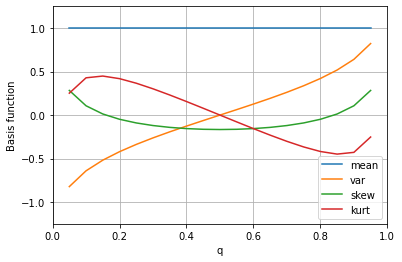

In [5]:
fig, ax = plt.subplots()
ax.plot(qs, mean_basis, label='mean')
ax.plot(qs, var_basis,  label='var')
ax.plot(qs, skew_basis, label='skew')
ax.plot(qs, kurtosis_basis, label='kurt')
ax.set(
    xlabel='q',
    ylabel='Basis function',
    xlim=(0,1), 
    ylim=(-1.25,1.25),
);
ax.legend(loc='lower right');
ax.grid();

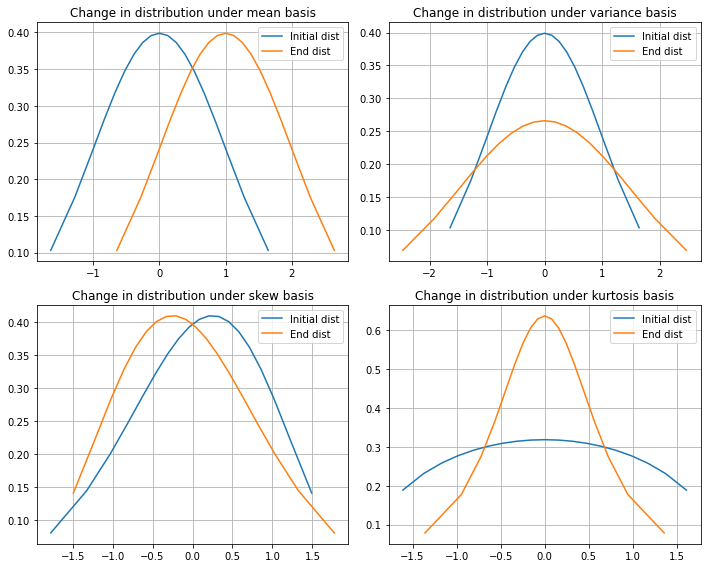

In [6]:
start_dist_list = ['norm', 'norm', 'pearson3', 'beta']
end_dist_list = ['norm', 'norm', 'pearson3', pearson7]    # Pearson7 is user-defined

start_args = [
    {'loc' : 0, 'scale':1},
    {'scale' : 1},
    {'loc': 0, 'scale':1, 'skew':-0.5},
    {'a': 1.5, 'b':1.5, 'loc':-2, 'scale': 4}
]
end_args = [
    {'loc' : 1, 'scale':1},
    {'scale' : 1.5},
    {'loc': 0, 'scale':1, 'skew':0.5},
    {'shape':2, 'loc': 0, 'scale': 1}
]
moments = ['mean', 'variance', 'skew', 'kurtosis']

fig, axes = plt.subplots(figsize=(10,8), nrows=2, ncols=2)
axes = axes.ravel()

for i in range(4):
    start_dist = getattr(sc.stats, start_dist_list[i])
    start_quantiles = start_dist.ppf(qs, **start_args[i])
    
    if isinstance(end_dist_list[i], str):
        end_dist = getattr(sc.stats, start_dist_list[i])
    else:
        end_dist = end_dist_list[i]
    end_quantiles = end_dist.ppf(qs, **end_args[i])

    axes[i].plot(start_quantiles, start_dist.pdf(start_quantiles, **start_args[i]), label='Initial dist')
    axes[i].plot(end_quantiles, end_dist.pdf(end_quantiles, **end_args[i]), label='End dist')
    axes[i].set_title('Change in distribution under {} basis'.format(moments[i]))
    axes[i].legend(loc='upper right')
    axes[i].grid()

fig.tight_layout()

In [7]:
print(pearson3.stats(loc=0, scale=1, skew=-0.5, moments='mvsk'))
print(beta.stats(a=1.5, b=1.5, loc=-2, scale=4, moments='mvsk'))

(array(0.), array(1.), array(-0.5), array(0.375))
(array(0.), array(1.), array(0.), array(-1.))


# Create nonstationary toy distribution

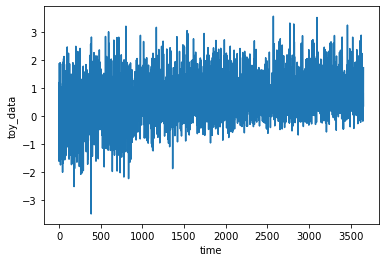

In [8]:
rng = np.random.default_rng(0)
n = 3653
data = np.zeros(n)
for i in range(n):
    data[i] = sc.stats.skewnorm.rvs(loc=0.1*i/n, a=0.001*i)
    # data[i] = norm.rvs(loc=0.1*i/n, scale=1 + 1*np.log(i+1))
timeseries = xr.DataArray(
    data, dims=('time',), coords={'time':np.arange(n)}, name='toy_data'
)
timeseries.plot()

# Perform quantile regression

In [9]:
# Preprocessing stuff
df = timeseries.to_dataframe().reset_index()
y, x = dmatrices('toy_data ~ time', data=df, return_type='dataframe')

In [10]:
# Perform quantile regression for a given quantile
qr = sm.regression.quantile_regression.QuantReg(y, x) 
result = qr.fit(q=0.05)
pred = result.predict(x)

Text(0.5, 1.0, 'Quantile regression on data with quantile spacing of 0.05')

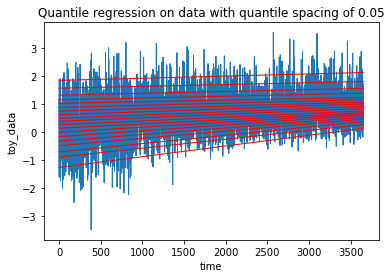

In [11]:
# Plot example quantile regression
fig, ax = plt.subplots()
timeseries.plot(ax=ax, lw=1)

qs = np.arange(0.05, 1.0, 0.05)

for q in qs:
    result = qr.fit(q=q)
    ax.plot(x['time'], result.predict(x), color='r', ls='-', lw=1)

ax.set_title('Quantile regression on data with quantile spacing of {:.2}'.format(qs[1] - qs[0]))

In [12]:
# Compute quantile changes for distribution
quantile_changes = np.zeros(len(qs))
for i, q in enumerate(qs):
    result = qr.fit(q=q)
    quantile_changes[i] = np.array(result.predict(x))[-1] - np.array(result.predict(x))[0]

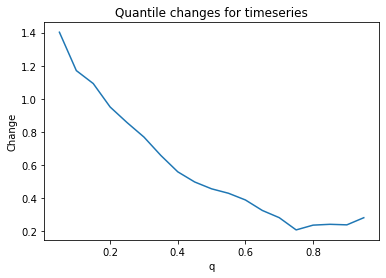

In [13]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes)
ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Change'
);

# Construct least squares solution in terms of moment basis functions

Let $v_1$, $v_2$, $v_3$, $v_4$, be the basis functions for a unit change in mean, variance, skewness, and kurtosis, respectively. Let $z$ be the change in quantiles in the observed data (plotted above). We seek a least squares solution for $z$ in terms of $v_1$, $v_2$, $v_3$, $v_4$; that is, 

$$
z \approx c_1 v_1 + c_2 v_2 + c_3 v_3 + c_4 v_4.
$$

Writing $A = [v_1, v_2, v_3, v_4 ]$ and $c = [c_1, c_2, c_3, c_4]^T$ we may write this as $ Ac \approx z$. The least squares problem becomes to find

$$
c = \underset{x}{\argmin} \|z - Ax\|_2^2
$$



In [14]:
A = np.zeros((len(qs), 4))
A[:,0] = mean_basis
A[:,1] = var_basis
A[:,2] = skew_basis
A[:,3] = kurtosis_basis

coeffs = linalg.lstsq(A, quantile_changes)[0]
coeffs

array([ 0.61645994, -0.59379766,  0.8546435 ,  0.25540559])

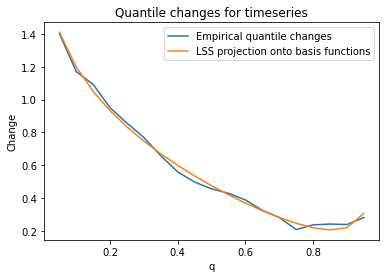

In [15]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes, label='Empirical quantile changes')
ax.plot(qs, A@coeffs, label='LSS projection onto basis functions')
ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Change'
)
ax.legend()

# Save values to attrs.py
See auxiliary python file.

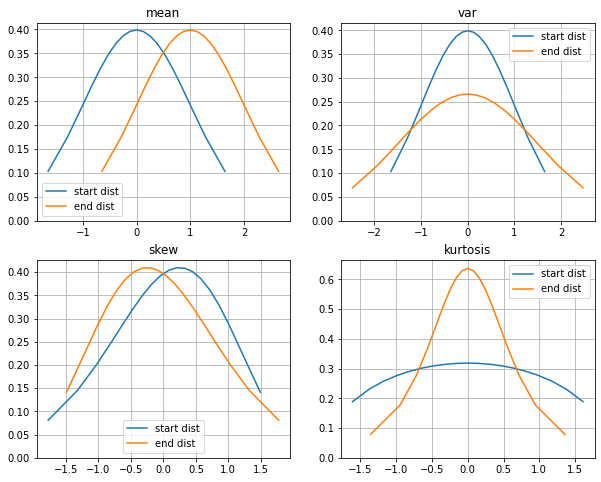

In [16]:
fig, axes = plt.subplots(figsize=(10,8), ncols=2, nrows=2)
axes = axes.ravel()

qs = attrs.qs
moments = attrs.moments
for i in range(4):
    start_dist = attrs.start_dist_list[i]
    start_args = attrs.start_args[i]
    end_dist = attrs.end_dist_list[i]
    end_args = attrs.end_args[i]

    start_quantiles = start_dist.ppf(qs, **start_args)
    end_quantiles = end_dist.ppf(qs, **end_args)

    axes[i].plot(
        start_quantiles, start_dist.pdf(start_quantiles, **start_args),
        label='start dist'
    )

    axes[i].plot(
        end_quantiles, end_dist.pdf(end_quantiles, **end_args),
        label='end dist'
    )
    axes[i].set(
        title=moments[i],
        ylim=(0,None)
    )
    axes[i].grid()
    axes[i].legend()

# Construct Legendre basis

In [17]:
# Determine  norm of each moment basis function
moment_basis_functions = attrs.moment_basis_functions

mean_scale = linalg.norm(moment_basis_functions['mean'])



mean       4.358898943540673
var        1.8826600931056197
skew       0.6346503424117206
kurtosis   1.3660220026674754


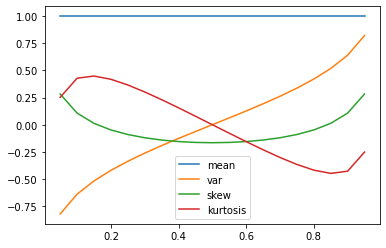

In [18]:
# Norms of each basis function
moment_basis_functions = attrs.moment_basis_functions
for moment in moment_basis_functions:
    plt.plot(qs, moment_basis_functions[moment], label=moment)
    print(
        '{:10s}'.format(moment),
        linalg.norm(moment_basis_functions[moment])
    )
plt.legend()

array([1.        , 0.78855954, 0.36046589, 0.95277938])

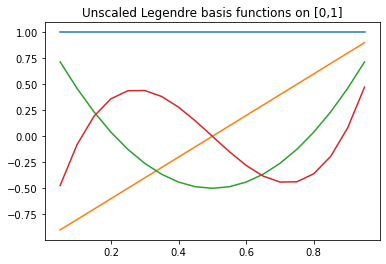

In [19]:
# Shift domain of legendre polynomials from default [-1,1] to [0,1]
def poly(x, n):
    # n'th
    y = 2*x - 1
    return legendre(n)(y)

for n in range(0,4):
    plt.plot(qs, poly(qs, n))
plt.title('Unscaled Legendre basis functions on [0,1]')

scalings = []
for i in range(4):
    moment_basis = list(moment_basis_functions.values())[i]
    unscaled_leg_basis = poly(qs, i)
    alpha = linalg.norm(moment_basis) / linalg.norm(unscaled_leg_basis)
    scalings.append(alpha)

scalings = np.array(scalings)
scalings

In [20]:
moments = ['mean', 'var', 'skew', 'kurtosis']
basis_funcs =  [
    scalings[i] * poly(qs, i) for i in range(4)
]

legendre_basis_functions = dict(zip(moments, basis_funcs))

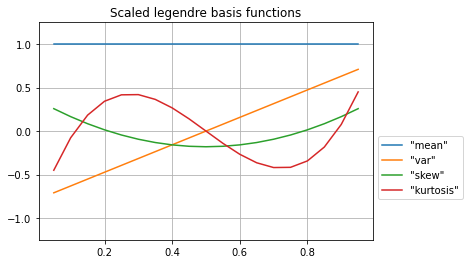

In [21]:
for moment, basis in legendre_basis_functions.items():
    plt.plot(qs, basis, 
             label='"{}"'.format(moment))
plt.title('Scaled legendre basis functions')
plt.ylim(-1.25,1.25)
plt.legend(bbox_to_anchor=(1,0.5))
plt.grid()

Text(0.5, 1.0, 'Scaled legendre basis functions')

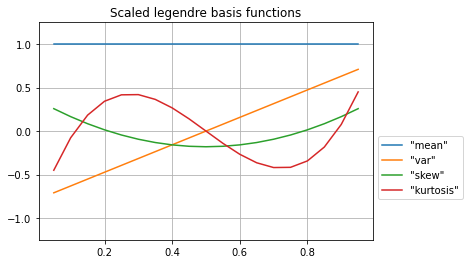

In [22]:
qs = attrs.qs
basis_functions = attrs.legendre_basis_functions
for moment, basis in basis_functions.items():
    plt.plot(qs, basis, label='"{}"'.format(moment))
plt.grid()
plt.legend(bbox_to_anchor=(1,0.5))
plt.ylim(-1.25,1.25)
plt.title('Scaled legendre basis functions')